In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve

np.random.seed(42)

/tmp/ipykernel_14206/3945237246.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
# CLEAN DATA - Remove all NaN and Inf values
print("Deep cleaning data...")

# Replace inf with NaN first
X_train = X_train.replace([np. inf, -np.inf], np.nan)
X_test = X_test.replace([np. inf, -np.inf], np.nan)

# Fill NaN with 0 (safe for scaled [0,1] data)
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Convert to numpy arrays (sometimes helps)
X_train_clean = X_train.values
X_test_clean = X_test.values

# Verify clean
print(f"X_train has NaN:  {np.isnan(X_train_clean).any()}")
print(f"X_train has Inf: {np.isinf(X_train_clean).any()}")
print(f"X_test has NaN:  {np.isnan(X_test_clean).any()}")
print(f"X_test has Inf: {np.isinf(X_test_clean).any()}")

print("✓ Data is clean!")

Deep cleaning data...
X_train has NaN:  False
X_train has Inf: False
X_test has NaN:  False
X_test has Inf: False
✓ Data is clean!


In [6]:
# Load train-test data
X_train = pd.read_csv('../data/processed/X_train_selected.csv')
X_test = pd.read_csv('../data/processed/X_test_selected.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

print(f"Training set:  {X_train.shape}")
print(f"Test set:  {X_test.shape}")
print(f"\nFeatures: {list(X_train.columns)}")
print(f"\nClass distribution in test set:")
print(f"  Non-Fraud: {sum(y_test == 0)}")
print(f"  Fraud: {sum(y_test == 1)}")

Training set:  (80000, 4)
Test set:  (20000, 4)

Features: ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'repeat_retailer']

Class distribution in test set:
  Non-Fraud: 18252
  Fraud: 1748


In [7]:
print("="*60)
print("Training Logistic Regression...")
print("="*60)

# Simple logistic regression (no tuning)
lr_model = LogisticRegression(max_iter=500, random_state=42, C=0.1)
lr_model.fit(X_train_clean, y_train)  # Use X_train_clean instead of X_train

# Predictions
y_pred_lr = lr_model. predict(X_test_clean)  # Use X_test_clean
y_proba_lr = lr_model.predict_proba(X_test_clean)[:, 1]

# Calculate metrics
acc_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, zero_division=0)
recall_lr = recall_score(y_test, y_pred_lr, zero_division=0)
f1_lr = f1_score(y_test, y_pred_lr, zero_division=0)
auc_lr = roc_auc_score(y_test, y_proba_lr)

print(f"\nLogistic Regression Results:")
print(f"  Accuracy:   {acc_lr:.4f}")
print(f"  Precision: {precision_lr:.4f}")
print(f"  Recall:     {recall_lr:.4f}")
print(f"  F1 Score:  {f1_lr:.4f}")
print(f"  AUC-ROC:   {auc_lr:.4f}")

Training Logistic Regression...

Logistic Regression Results:
  Accuracy:   0.9137
  Precision: 0.6719
  Recall:     0.0246
  F1 Score:  0.0475
  AUC-ROC:   0.9128


In [8]:
print("\n" + "="*60)
print("Training Decision Tree...")
print("="*60)

# Simple decision tree with limited depth
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42, min_samples_split=20)
dt_model.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_model.predict(X_test)
y_proba_dt = dt_model.predict_proba(X_test)[:, 1]

# Calculate metrics
acc_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, zero_division=0)
recall_dt = recall_score(y_test, y_pred_dt, zero_division=0)
f1_dt = f1_score(y_test, y_pred_dt, zero_division=0)
auc_dt = roc_auc_score(y_test, y_proba_dt)

print(f"\nDecision Tree Results:")
print(f"  Accuracy:   {acc_dt:.4f}")
print(f"  Precision: {precision_dt:.4f}")
print(f"  Recall:    {recall_dt:.4f}")
print(f"  F1 Score:  {f1_dt:.4f}")
print(f"  AUC-ROC:   {auc_dt:.4f}")


Training Decision Tree...

Decision Tree Results:
  Accuracy:   0.9391
  Precision: 0.6238
  Recall:    0.7637
  F1 Score:  0.6867
  AUC-ROC:   0.9710


In [9]:
print("\n" + "="*60)
print("Training Random Forest...")
print("="*60)

# Limited random forest (fewer trees, limited depth)
rf_model = RandomForestClassifier(
    n_estimators=50, 
    max_depth=5, 
    random_state=42,
    min_samples_split=10
)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Calculate metrics
acc_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, zero_division=0)
recall_rf = recall_score(y_test, y_pred_rf, zero_division=0)
f1_rf = f1_score(y_test, y_pred_rf, zero_division=0)
auc_rf = roc_auc_score(y_test, y_proba_rf)

print(f"\nRandom Forest Results:")
print(f"  Accuracy:   {acc_rf:.4f}")
print(f"  Precision: {precision_rf:.4f}")
print(f"  Recall:    {recall_rf:.4f}")
print(f"  F1 Score:  {f1_rf:.4f}")
print(f"  AUC-ROC:   {auc_rf:.4f}")


Training Random Forest...

Random Forest Results:
  Accuracy:   0.9394
  Precision: 0.6244
  Recall:    0.7695
  F1 Score:  0.6894
  AUC-ROC:   0.9715


In [10]:
print("\n" + "="*60)
print("Training XGBoost...")
print("="*60)

# Limited XGBoost
xgb_model = XGBClassifier(
    n_estimators=50, 
    max_depth=4, 
    learning_rate=0.05,
    random_state=42,
    eval_metric='logloss',
    verbosity=0
)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Calculate metrics
acc_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, zero_division=0)
recall_xgb = recall_score(y_test, y_pred_xgb, zero_division=0)
f1_xgb = f1_score(y_test, y_pred_xgb, zero_division=0)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

print(f"\nXGBoost Results:")
print(f"  Accuracy:  {acc_xgb:.4f}")
print(f"  Precision: {precision_xgb:.4f}")
print(f"  Recall:    {recall_xgb:.4f}")
print(f"  F1 Score:   {f1_xgb:.4f}")
print(f"  AUC-ROC:   {auc_xgb:.4f}")


Training XGBoost...

XGBoost Results:
  Accuracy:  0.9387
  Precision: 0.6236
  Recall:    0.7546
  F1 Score:   0.6829
  AUC-ROC:   0.9710


In [11]:
# Create results dataframe
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy': [acc_lr, acc_dt, acc_rf, acc_xgb],
    'Precision': [precision_lr, precision_dt, precision_rf, precision_xgb],
    'Recall': [recall_lr, recall_dt, recall_rf, recall_xgb],
    'F1-Score':  [f1_lr, f1_dt, f1_rf, f1_xgb],
    'AUC-ROC': [auc_lr, auc_dt, auc_rf, auc_xgb]
})

print("\n" + "="*70)
print("CLASSICAL MODELS - PERFORMANCE SUMMARY")
print("="*70)
print(results.to_string(index=False))
print("="*70)

# Find best model
best_idx = results['AUC-ROC'].idxmax()
print(f"\nBest Model: {results.loc[best_idx, 'Model']}")
print(f"Best AUC-ROC: {results.loc[best_idx, 'AUC-ROC']:.4f}")


CLASSICAL MODELS - PERFORMANCE SUMMARY
              Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
Logistic Regression   0.91370   0.671875 0.024600  0.047461 0.912793
      Decision Tree   0.93910   0.623832 0.763730  0.686728 0.971002
      Random Forest   0.93940   0.624420 0.769451  0.689390 0.971478
            XGBoost   0.93875   0.623641 0.754577  0.682889 0.971002

Best Model: Random Forest
Best AUC-ROC: 0.9715


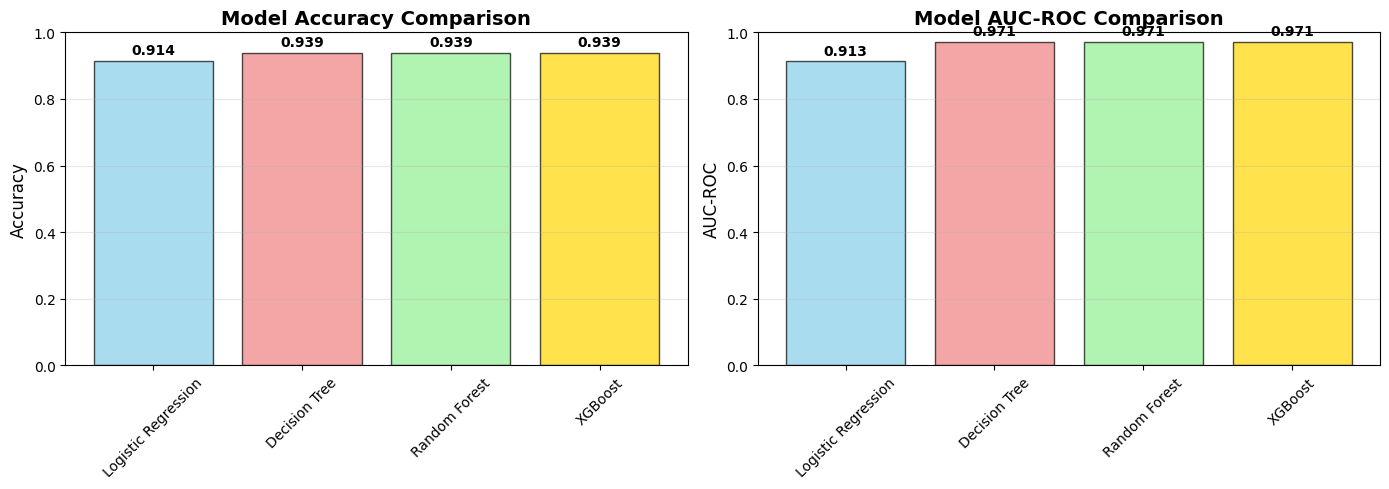

✓ Figure saved:  figures/classical_comparison.png


In [12]:
# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy
axes[0].bar(results['Model'], results['Accuracy'], 
            color=['skyblue', 'lightcoral', 'lightgreen', 'gold'], 
            edgecolor='black', alpha=0.7)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_ylim([0, 1])
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(results['Accuracy']):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Plot 2: AUC-ROC
axes[1].bar(results['Model'], results['AUC-ROC'], 
            color=['skyblue', 'lightcoral', 'lightgreen', 'gold'], 
            edgecolor='black', alpha=0.7)
axes[1].set_title('Model AUC-ROC Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('AUC-ROC', fontsize=12)
axes[1].set_ylim([0, 1])
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(results['AUC-ROC']):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
os.makedirs('../figures', exist_ok=True)
plt.savefig('../figures/classical_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure saved:  figures/classical_comparison.png")

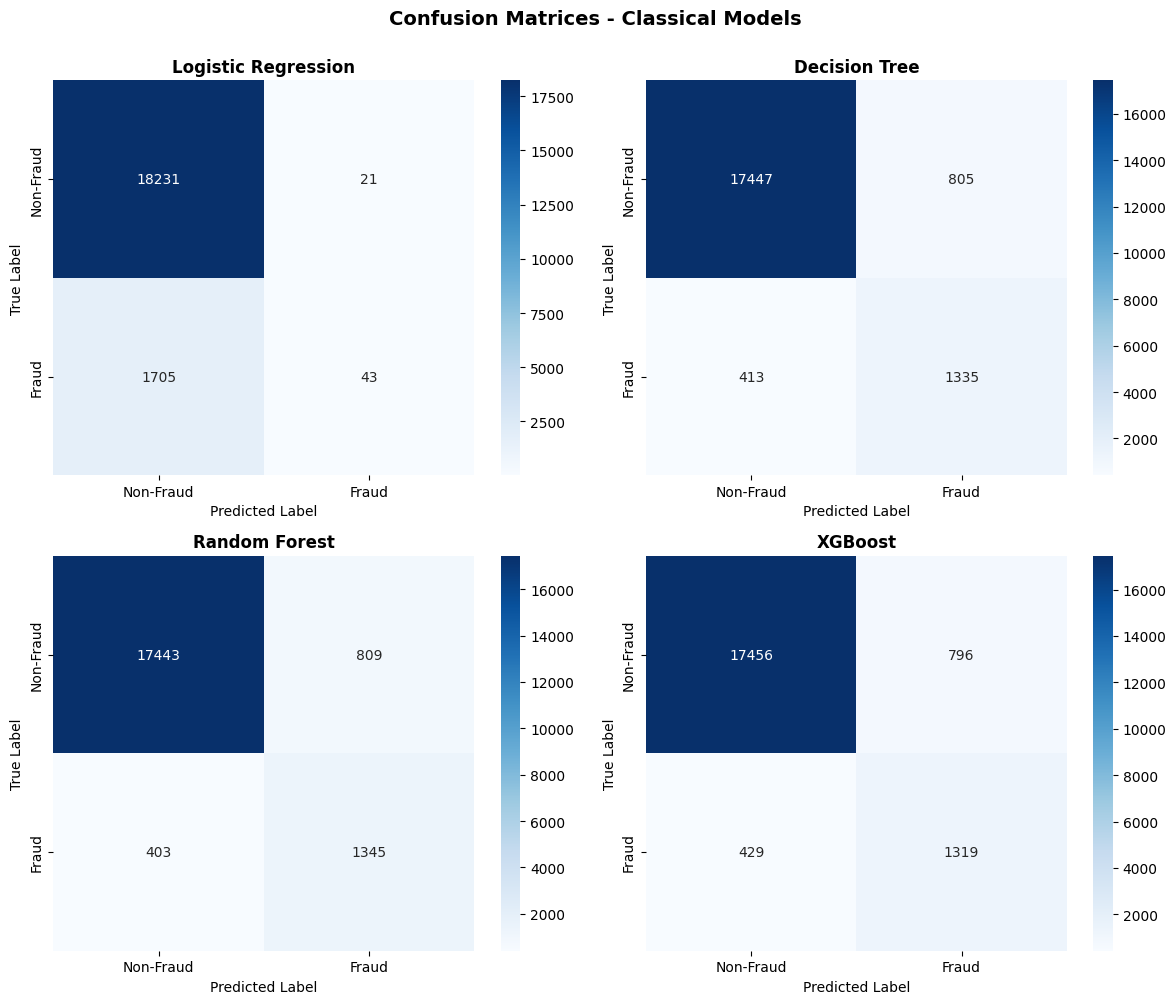

✓ Figure saved: figures/confusion_matrices.png


In [13]:
# Plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

predictions = [
    (y_pred_lr, 'Logistic Regression'),
    (y_pred_dt, 'Decision Tree'),
    (y_pred_rf, 'Random Forest'),
    (y_pred_xgb, 'XGBoost')
]

for idx, (y_pred, name) in enumerate(predictions):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Non-Fraud', 'Fraud'],
                yticklabels=['Non-Fraud', 'Fraud'])
    axes[idx].set_title(f'{name}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.suptitle('Confusion Matrices - Classical Models', fontsize=14, fontweight='bold', y=1.0)
plt.tight_layout()
plt.savefig('../figures/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure saved: figures/confusion_matrices.png")

In [14]:
# Create directories
os.makedirs('../models', exist_ok=True)
os.makedirs('../results', exist_ok=True)

# Save models
joblib.dump(lr_model, '../models/lr_model.pkl')
joblib.dump(dt_model, '../models/dt_model.pkl')
joblib.dump(rf_model, '../models/rf_model.pkl')
joblib.dump(xgb_model, '../models/xgb_model.pkl')

# Save results
results.to_csv('../results/classical_results.csv', index=False)

# Save predictions for later analysis
predictions_df = pd.DataFrame({
    'y_true': y_test,
    'lr_pred': y_pred_lr,
    'lr_proba': y_proba_lr,
    'dt_pred': y_pred_dt,
    'dt_proba':  y_proba_dt,
    'rf_pred': y_pred_rf,
    'rf_proba': y_proba_rf,
    'xgb_pred': y_pred_xgb,
    'xgb_proba': y_proba_xgb
})
predictions_df.to_csv('../results/classical_predictions.csv', index=False)

print("✓ Models saved to: models/")
print("✓ Results saved to: results/classical_results.csv")
print("✓ Predictions saved to:  results/classical_predictions.csv")

✓ Models saved to: models/
✓ Results saved to: results/classical_results.csv
✓ Predictions saved to:  results/classical_predictions.csv


In [48]:
print("\n" + "="*70)
print("CLASSICAL BASELINES COMPLETE")
print("="*70)
print(f"\nModels trained:  4")
print(f"  - Logistic Regression")
print(f"  - Decision Tree")
print(f"  - Random Forest")
print(f"  - XGBoost")
print(f"\nBest performing model (AUC-ROC): {results.loc[best_idx, 'Model']}")
print(f"Score: {results.loc[best_idx, 'AUC-ROC']:.4f}")
print("\n✓ Ready for Quantum models!")
print("="*70)


CLASSICAL BASELINES COMPLETE

Models trained:  4
  - Logistic Regression
  - Decision Tree
  - Random Forest
  - XGBoost

Best performing model (AUC-ROC): Random Forest
Score: 0.9715

✓ Ready for Quantum models!
